# Loading the dataset --> [MIR-1K](https://www.kaggle.com/datasets/datongmuyuyi/mir1k?resource=download) 

In [ ]:
import sys
import os
import importlib.util

def load_local_module(name, path):
    spec = importlib.util.spec_from_file_location(name, path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[name] = module
    spec.loader.exec_module(module)
    return module

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')

dataset_mod = load_local_module("src.dataset", os.path.join(src_dir, 'dataset.py'))
vae_mod = load_local_module("src.vae", os.path.join(src_dir, 'vae.py'))
eval_mod = load_local_module("src.evaluation", os.path.join(src_dir, 'evaluation.py'))

In [ ]:
import os
os.path.exists("../data/audio") 

True

In [26]:
from src.dataset import load_audio_features

X, files = load_audio_features("../data/audio")
X.shape


(1000, 40)

# Easy tasks 

## Baseline check

In [ ]:
from src.dataset import load_audio_features
from src.clustering import pca_kmeans
from src.evaluation import evaluate_clustering

X, _ = load_audio_features("../data/audio")
X_pca, labels = pca_kmeans(X)
metrics = evaluate_clustering(X_pca, labels)
metrics


{'silhouette': 0.23751388490200043, 'calinski_harabasz': 524.6562049913216}

## Visualizing the baseline cluster

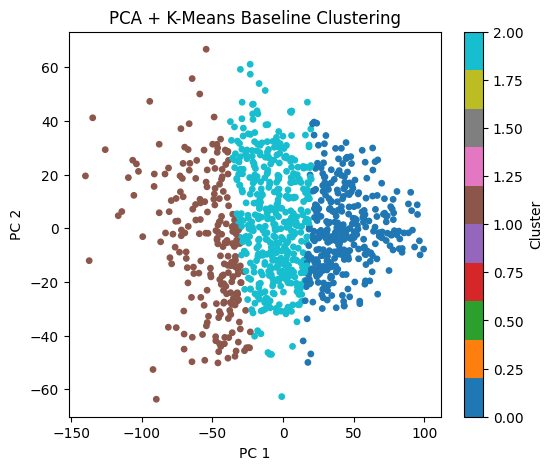

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=15)
plt.title("PCA + K-Means Baseline Clustering")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
plt.savefig("../results/pca_kmeans_baseline.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

## VAE Training


### Data Scaling & VAE Training

In [ ]:
from sklearn.preprocessing import StandardScaler
from src.vae import train_vae, get_latent_features

# 1. Scaling the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Train VAE  input_dim=40  latent_dim=10
vae_model = train_vae(X_scaled, input_dim=40, latent_dim=10, epochs=100)

# 3. Extracting Latent Features
X_vae = get_latent_features(vae_model, X_scaled)

print("VAE Latent Shape:", X_vae.shape)


Training VAE...
Epoch 10/100, Loss: 35.0329
Epoch 20/100, Loss: 32.9510
Epoch 30/100, Loss: 32.0302
Epoch 40/100, Loss: 31.1642
Epoch 50/100, Loss: 30.5421
Epoch 60/100, Loss: 29.5441
Epoch 70/100, Loss: 28.9405
Epoch 80/100, Loss: 28.4004
Epoch 90/100, Loss: 28.1896
Epoch 100/100, Loss: 27.9518
VAE Latent Shape: (1000, 10)


### VAE Clustering & Evaluation

In [ ]:
from sklearn.cluster import KMeans
from src.evaluation import evaluate_clustering

# 1. Cluster on VAE features
kmeans_vae = KMeans(n_clusters=3, random_state=42)
labels_vae = kmeans_vae.fit_predict(X_vae)

# 2. Evaluate
metrics_vae = evaluate_clustering(X_vae, labels_vae)
print("VAE + KMeans Metrics:", metrics_vae)

# Compare with Baseline
print("Baseline (PCA) Metrics:", metrics)


VAE + KMeans Metrics: {'silhouette': 0.16103796660900116, 'calinski_harabasz': 173.7454682253214}
Baseline (PCA) Metrics: {'silhouette': 0.23751388490200043, 'calinski_harabasz': 524.6562049913216}


### Visualization & Comparison

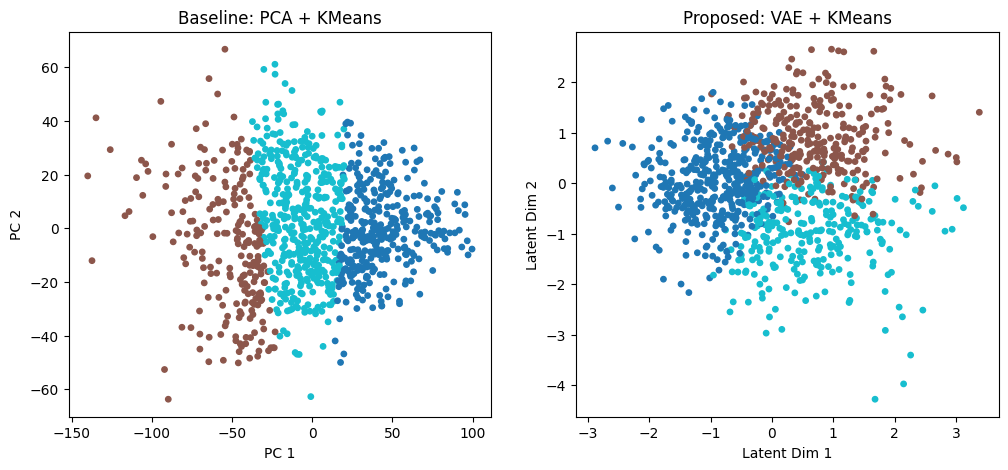

       method  silhouette  calinski_harabasz
0  PCA+KMeans    0.237514         524.656205
1  VAE+KMeans    0.161038         173.745468


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Visualize VAE Clusters
plt.figure(figsize=(12, 5))

# Plot PCA Baseline (re-using your previous vars)
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=15)
plt.title("Baseline: PCA + KMeans")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

# Plot VAE Clusters X_vae is 10-dim, so we need PCA just to visualize it in 2D
from sklearn.decomposition import PCA
pca_viz = PCA(n_components=2)
X_vae_2d = pca_viz.fit_transform(X_vae)

plt.subplot(1, 2, 2)
plt.scatter(X_vae_2d[:, 0], X_vae_2d[:, 1], c=labels_vae, cmap='tab10', s=15)
plt.title("Proposed: VAE + KMeans")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")

plt.show()

# 2. Save Comparison
results = [
    {"method": "PCA+KMeans", **metrics},
    {"method": "VAE+KMeans", **metrics_vae}
]
df_results = pd.DataFrame(results)
print(df_results)
df_results.to_csv("../results/clustering_comparison.csv", index=False)


# Medium Task

In [5]:
# Cell: Medium Task Execution
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score

### Loading Hybrid Data with Labels

In [3]:
X_hybrid, y_true, label_encoder, filenames = dataset_mod.load_hybrid_data_with_labels("../data/audio", "../data/lyrics")

print(f"Data Shape: {X_hybrid.shape}")
print(f"Number of Singers (Classes): {len(label_encoder.classes_)}")

Data Shape: (1000, 90)
Number of Singers (Classes): 19


### Training Convolutional VAE

In [6]:
# Scale Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_hybrid)


conv_vae = vae_mod.train_conv_vae(X_scaled, input_dim=90, latent_dim=10, epochs=50)

X_latent = vae_mod.get_latent_conv(conv_vae, X_scaled)
print(f"Latent Shape: {X_latent.shape}")

Training Convolutional VAE...
Latent Shape: (1000, 10)


### Clustering & Evaluation (ARI + Metrics)

In [ ]:
algorithms = {
    "KMeans": KMeans(n_clusters=3, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=3),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5) 
}

results = []

for name, algo in algorithms.items():
    # Cluster
    labels_pred = algo.fit_predict(X_latent)
    
    metrics = eval_mod.evaluate_clustering(X_latent, labels_pred)
    
    metrics["ARI"] = adjusted_rand_score(y_true, labels_pred)
    
    metrics['method'] = name
    results.append(metrics)

### Storing the results

In [8]:
print("\n--- Final Results ---")
df_results = pd.DataFrame(results)
print(df_results)

# Save
df_results.to_csv("../results/medium_task_final.csv", index=False)
print("\nSaved results to results/medium_task_final.csv")


--- Final Results ---
   silhouette   calinski  davies_bouldin       ARI         method  \
0    0.112473  82.247037        2.439855  0.021121         KMeans   
1    0.118844  56.729338        2.990405  0.015497  Agglomerative   
2         NaN        NaN             NaN  0.000000         DBSCAN   

                        error  
0                         NaN  
1                         NaN  
2  Less than 2 clusters found  

Saved results to results/medium_task_final.csv


# Hard Tasks

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import sys
import os
import importlib.util

# --- Helper Function Definitions ---
def load_local_module(name, path):
    spec = importlib.util.spec_from_file_location(name, path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[name] = module
    spec.loader.exec_module(module)
    return module

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')

In [5]:
dataset_mod = load_local_module("src.dataset", os.path.join(src_dir, 'dataset.py'))
vae_mod = load_local_module("src.vae", os.path.join(src_dir, 'vae.py'))
eval_mod = load_local_module("src.evaluation", os.path.join(src_dir, 'evaluation.py'))

### Load Data & Labels

In [ ]:
X_hybrid, y_encoded, label_encoder, _ = dataset_mod.load_hybrid_data_with_labels("../data/audio", "../data/lyrics")
num_classes = len(label_encoder.classes_)
print(f"Classes (Singers): {num_classes}")

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_hybrid)

### Training Conditional VAE (CVAE) 

In [ ]:
cvae = vae_mod.train_cvae(X_scaled, y_encoded, num_classes=num_classes, input_dim=90, latent_dim=10, epochs=50)

X_cvae_latent = vae_mod.get_cvae_latent(cvae, X_scaled, y_encoded, num_classes)
print(f"CVAE Latent Shape: {X_cvae_latent.shape}")


--- Step 2: Train Conditional VAE (CVAE) ---
Training CVAE with 19 classes...
CVAE Latent Shape: (1000, 10)


### Clustering & Evaluation

In [ ]:


k = num_classes 
print(f"Clustering with K={k} (Ground Truth Count)...")


--- Step 3: Clustering & Evaluation ---
Clustering with K=19 (Ground Truth Count)...


In [ ]:
kmeans_cvae = KMeans(n_clusters=k, random_state=42)
labels_pred_cvae = kmeans_cvae.fit_predict(X_cvae_latent)


metrics_hard = eval_mod.evaluate_clustering(X_cvae_latent, labels_pred_cvae, labels_true=y_encoded)
metrics_hard["method"] = "CVAE+KMeans"

### Hard Task Results

In [ ]:
df_hard = pd.DataFrame([metrics_hard])
print(df_hard)

df_hard.to_csv("../results/hard_task_final.csv", index=False)
print("\nSaved results to results/hard_task_final.csv")


--- Final Hard Task Results ---
   silhouette   calinski  davies_bouldin       ARI       NMI  Purity  \
0    0.102293  69.321991        1.453826  0.016694  0.115567   0.173   

        method  
0  CVAE+KMeans  

Saved results to results/hard_task_final.csv
